In [1]:
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
import json
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
COMPUTED_DATA_PATH = 'temp_data/reddit/preprocessed/'
TEMP_DATA_PATH = 'temp_data/reddit/unchunked/'

In [5]:
class AV_Model(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(input_sz, hidden_sz),
            nn.Dropout(p=0.5)
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_sz, 1),
            nn.Dropout(p=0.5)
        )
    
    def forward_once(self, x):
        x = F.relu(self.fc_1(x))
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        x = torch.abs(x1 - x2)
        x = torch.sigmoid(self.fc_2(x))
        
        return x

In [6]:
class PANDataset(torch.utils.data.Dataset):
    def __init__(self, x_1_path, x_2_path, y_path, vector_sz, feature_sz):
        self.XX_1 = np.memmap(x_1_path, dtype='float32', mode='r', shape=(vector_sz, feature_sz))
        self.XX_2 = np.memmap(x_2_path, dtype='float32', mode='r', shape=(vector_sz, feature_sz))
        
        self.Y = np.memmap(y_path, dtype='int32', mode='r', shape=(vector_sz))


    def __getitem__(self, index):
        x_1 = np.array(self.XX_1[index, :])
        x_2 = np.array(self.XX_2[index, :])
        return x_1, x_2, np.array(self.Y[index]).astype('float32')

    def __len__(self):
        return len(self.Y)
    

In [7]:
DATA_DIR = 'data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
PREPROCESSED_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'
# TEMP_DATA_PATH = 'temp_data/pan/'
TEMP_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'

In [8]:
with open(TEMP_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)

/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jnw301/.local/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.22.1 when using version 0.24.1. This might lead to breaking code

In [10]:
model = torch.load(TEMP_DATA_PATH + 'pytorch_model.pt')
# model.to(device)

In [14]:
train = PANDataset(TEMP_DATA_PATH + 'vectorized_XX_1_train.npy', TEMP_DATA_PATH + 'vectorized_XX_2_train.npy', TEMP_DATA_PATH + 'Y_train.npy', train_sz, feature_sz)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)

test = PANDataset(TEMP_DATA_PATH + 'vectorized_XX_1_train.npy', TEMP_DATA_PATH + 'vectorized_XX_2_train.npy', TEMP_DATA_PATH + 'Y_train.npy', test_sz, feature_sz)
test_loader = torch.utils.data.DataLoader(test, batch_size=4096, shuffle=False)

In [15]:
for x1, x2, y in test_loader:
#     x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    x1_out = model.forward_once(x1)
    x2_out = model.forward_once(x2)
    xx = model.fc_2(torch.abs(x1_out - x2_out)).cpu().detach().numpy()
    x1_out = x1_out.cpu().detach().numpy()
    x2_out = x2_out.cpu().detach().numpy()
    break

In [23]:
tsne = TSNE(n_components=2, verbose=1, n_iter=4000)
# tsne_results = tsne.fit_transform(np.vstack([x1_out, x2_out]))
# tsne_results = tsne.fit_transform(xx)
tsne_results = tsne.fit_transform(np.abs(x1_out - x2_out))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4096 samples in 0.001s...
[t-SNE] Computed neighbors for 4096 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4096
[t-SNE] Computed conditional probabilities for sample 2000 / 4096
[t-SNE] Computed conditional probabilities for sample 3000 / 4096
[t-SNE] Computed conditional probabilities for sample 4000 / 4096
[t-SNE] Computed conditional probabilities for sample 4096 / 4096
[t-SNE] Mean sigma: 8.913115
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.218407
[t-SNE] KL divergence after 4000 iterations: 2.918640


In [46]:
x1_tsne = tsne_results[:len(y), :]
x2_tsne = tsne_results[len(y):, :]

In [47]:
tsne_results.shape, x1_tsne.shape, len(y)

((8192, 2), (4096, 2), 4096)

In [25]:
y = y.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

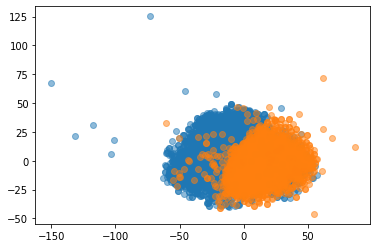

In [26]:
plt.scatter(tsne_results[y==0, 0], tsne_results[y==0, 1], alpha=0.5)
plt.scatter(tsne_results[y==1, 0], tsne_results[y==1, 1], alpha=0.5)

In [115]:
model.eval()
preds = []
labels = []
for x1, x2, y in test_loader:
    out = model(x1, x2).reshape(-1).tolist()
    y = y.reshape(-1).tolist()
    preds.extend(out)
    labels.extend(y)

In [116]:
fpr, tpr, thresh = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.97445313162784


In [117]:
torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')

In [26]:
x1.shape

torch.Size([64, 18373])